## 1. Introduction

This notebook will demonstrate tools to simulate color deficiencies, calculate color contrast to check the accessibility guidelines of WGCA

### Software Instalation
Open a new terminal and use pip

### 1.1 Package Imports

In [10]:
import PIL
import numpy as np
from daltonlens import convert, simulate, generate
import matplotlib.pyplot as plt
import glasbey
import seaborn as sns


### 1.2 Define Functions and Parameters

Setting the plot format parameters

In [2]:
%matplotlib inline
plt.style.use('tableau-colorblind10')

### Color Contrast 

In [7]:
def luminance(r, g, b):
    """
    Calculate the relative luminance of a color based on its RGB values.

    The function converts the RGB values to a luminance value according to
    the formula specified by the WCAG guidelines, which accounts for the
    human eye's sensitivity to different colors.

    Parameters
    ----------
    r : int
        The red component of the color, in the range 0-255.
    g : int
        The green component of the color, in the range 0-255.
    b : int
        The blue component of the color, in the range 0-255.

    Returns
    -------
    float
        The relative luminance of the color.
    """
    a = [r, g, b]
    for i in range(3):
        a[i] = a[i] / 255.0
        a[i] = a[i] / 12.92 if a[i] <= 0.03928 else ((a[i] + 0.055) / 1.055) ** 2.4
    return a[0] * 0.2126 + a[1] * 0.7152 + a[2] * 0.0722

def contrast_ratio(color1, color2):
    """
    Calculate the contrast ratio between two colors.

    The contrast ratio is computed based on the luminance values of the two colors,
    following the WCAG guidelines. It is used to determine the readability of text
    or the visibility of UI components against background colors.

    Parameters
    ----------
    color1 : tuple
        A tuple representing the RGB values of the first color.
    color2 : tuple
        A tuple representing the RGB values of the second color.

    Returns
    -------
    float
        The contrast ratio between the two colors.
    """
    l1 = luminance(*color1)
    l2 = luminance(*color2)
    if l1 > l2:
        return (l1 + 0.05) / (l2 + 0.05)
    else:
        return (l2 + 0.05) / (l1 + 0.05)

def hex_to_rgb(hex_color):
    """
    Convert a hexadecimal color code to an RGB tuple.

    This function takes a hexadecimal color string and converts it into a
    tuple of integers representing the red, green, and blue components of the color.

    Parameters
    ----------
    hex_color : str
        A string representing the hexadecimal color code, e.g., '#RRGGBB'.

    Returns
    -------
    tuple
        A tuple of three integers (R, G, B) representing the color in RGB format.
    """
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

def check_contrast(ratio):
    """
    Evaluate the contrast ratio against WCAG guidelines for different text and UI component sizes.

    The function checks whether the given contrast ratio meets the WCAG requirements
    for normal text, large text, and graphical UI components under different compliance levels.

    Parameters
    ----------
    ratio : float
        The contrast ratio to evaluate.

    Returns
    -------
    dict
        A dictionary with the results for different WCAG criteria, indicating 'Pass' or 'Fail'.
    """
    results = {
        "Normal Text AA": ratio >= 4.5,
        "Large Text AA": ratio >= 3,
        "Graphics/UI Components AA": ratio >= 3,
        "Normal Text AAA": ratio >= 7,
        "Large Text AAA": ratio >= 4.5
    }
    return results

## 2 Color contrast 

In [9]:
# Example 
color1 = "#3D7555"
color2 = "#0400FB"
rgb1 = hex_to_rgb(color1)
rgb2 = hex_to_rgb(color2)

ratio = contrast_ratio(rgb1, rgb2)
results = check_contrast(ratio)

print(f"The contrast ratio between {color1} and {color2} is: {ratio:.2f}")
print("Pass/Fail Criteria:")
for criteria, passed in results.items():
    print(f"{criteria}: {'Pass' if passed else 'Fail'}") 

The contrast ratio between #3D7555 and #0400FB is: 1.62
Pass/Fail Criteria:
Normal Text AA: Fail
Large Text AA: Fail
Graphics/UI Components AA: Fail
Normal Text AAA: Fail
Large Text AAA: Fail


## 3. Demonstration of Glasbey software

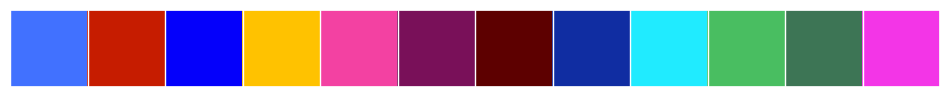

In [11]:
# Eric and Alex used glasbey to define their palettes
sns.set()
palette_glasbey = glasbey.create_palette(palette_size=12, colorblind_safe=True, cvd_severity=100)
sns.palplot(palette_glasbey)
# Glasbey_dark_alex

## 4. Demonstration DalTonLens Software

We'll demonstrate the DalTonLens software to simulate vision deficiencies. 

There are many simulators out there, this website does a good comparison and also provides an implementation based on papers for different deficiencies:https://daltonlens.org/opensource-cvd-simulation/ 



Choosing Viénot 1999 for protanopia
Choosing Viénot 1999 for deuteranopia
Choosing Brettel 1997 for tritanopia / tritanomaly


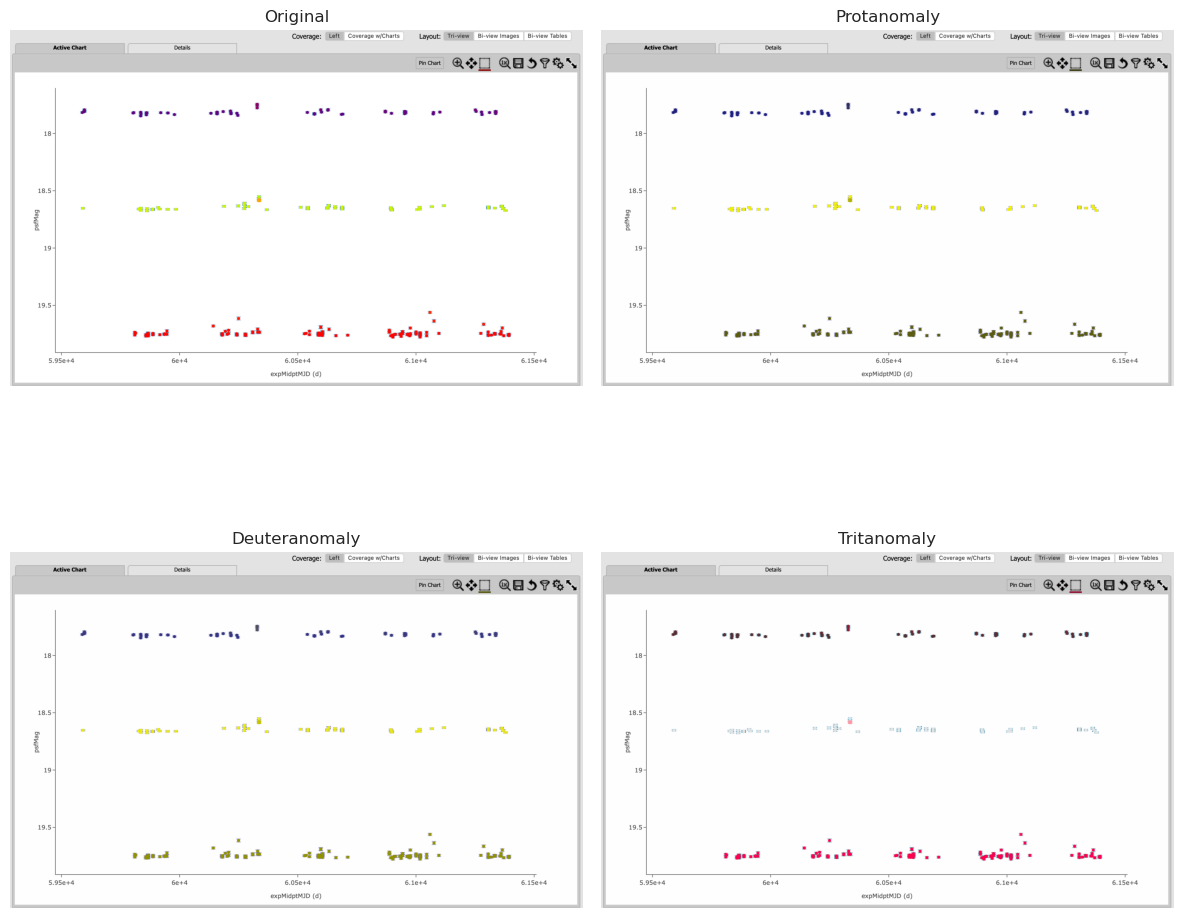

In [12]:
from daltonlens import convert, simulate, generate
import PIL


# Generate a test image that spans the RGB range
file = "./figures/ucd-lc-portal-screenshot.png"
im = np.asarray(PIL.Image.open(file).convert('RGB'))

# Auoselect best model
#"""Automatically selects the best algorithm for the given deficiency and severity.
#    - For tritan simulations it always picks (Brettel & Molon, 1997)
#    - For protanomaly/deuteranomly (severity < 1) it picks (Machado, 2009)
#    - For protanopia/deuteranopia (severity = 1) it picks (Vienot, 1999)
#"""
simulator = simulate.Simulator_AutoSelect()

# Define the color deficiencies
color_anomalies = [
    ("Original", None), 
    ("Protanomaly", simulate.Deficiency.PROTAN), 
    ("Deuteranomaly", simulate.Deficiency.DEUTAN), 
    ("Tritanomaly", simulate.Deficiency.TRITAN)
]

# Create a 2x2 grid for plotting
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

for idx, (title, deficiency) in enumerate(color_anomalies):
    ax = axs[idx // 2, idx % 2]
    
    if deficiency is None:
        # Show the original image
        display_im = im
    else:
        # Apply the simulator to the input image to get a simulation of the color anomaly
        display_im = simulator.simulate_cvd(im, deficiency, severity=1.0)
    
    ax.imshow(display_im)
    ax.set_title(title)
    ax.axis('off')  # Hide the axis

plt.tight_layout()
plt.show()

In [ ]:
#The following docstrings are from `simulate.py` in `DaltonLens`.

# Machado 2009: 
#     """The model proposed by (MacHado & Oliveira & Fernandes, 2009)
#
#    'A physiologically-based model for simulation of color vision deficiency'
#
#    This model is similar to Brettel1997 for dichromacy (it actually uses it
#    as a reference to scale the parameters), but is able to simulate various
#    severity levels by shifting the peak wavelength for a given cone, which
#    is more a more sounded way than simply interpolating with the original
#    image. However that model does not work well for tritanopia.

#Brettel & Molon, 1997
#    """Algorithm of (Brettel, Viénot & Mollon, 1997).
#    'Computerized simulation of color appearance for dichromats'
#
#    This model is a bit more complex than (Viénot & Brettel & Mollon, 1999)
#    but it works well for tritanopia. It is also the most solid reference
#    in the literature.

# Vienot, 1999
#    """Algorithm of (Viénot & Brettel & Mollon, 1999).
#
#    'Digital video colourmaps for checking the legibility of displays by dichromats.'
#
#    Recommended for protanopia and deuteranopia, but not accurate for tritanopia.    
#    """